In [1]:
from collections import Counter

import emoji
#import ktrain
import numpy as np
import pandas as pd
import seaborn as sns
#from eli5.lime import TextExplainer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from twitterFunctions.cross_validation import run_SVM_CV
from twitterFunctions.performanceMetrics import get_performance
from twitterFunctions.processing import (
    fix_emotes,
    process_token_fin,
    process_tweet,
)
from twitterFunctions.training import predict_test, set_seeds, train_learner


plt.rcdefaults()


SEED = 1

In [2]:
# load training data
file = "./data/training_posts20201201_main_categories.tsv"
# read training data
df = pd.read_csv(file, sep="\t")

In [3]:
# remove exxagerations, we tested the impact, but ended up using the full data
#df = df[df["ambiguous"] != "exaggeration"]

In [4]:
# filter relevant columns
df = df[["notserious_unclear", "focus", "type", "about_suicide", "contents"]]
# rename class and text columns
col_names = ["notserious_unclear", "focus", "type", "class", "text"]
df.columns=col_names
# mapping of 0's and 1's to correct and false
di = {
    1: "correct", # you can map it as you see fit
    0: "false",
}

df["class"].replace(di, inplace=True)

In [5]:
df.head()

,notserious_unclear,focus,type,class,text
0,0,1,4,correct,This is why joking about suicide on social med...
1,0,1,4,correct,Impulse - Ellen Hopkins-three teens meet in ho...
2,0,1,4,correct,@User A darker subjectPeople who want to commi...
3,0,1,4,correct,"@User Dear God,Please continue working miracle..."
4,0,1,4,correct,It Just Keeps Getting Worse: The Braxton Caner...


<module 'matplotlib.pyplot' from '/Users/hubertbaginski/GitHub/TwitterSuicideML/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

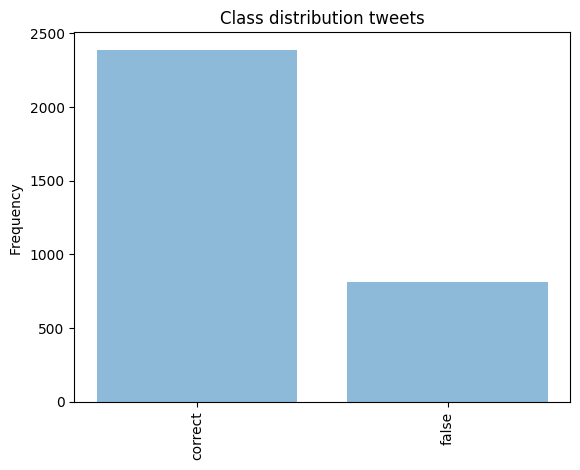

In [6]:
# here we print the class frequency distributions
freq_combined = Counter(df["class"].values)
objects = []
values = []
for i in freq_combined.keys():
    objects.append(i)
for i in freq_combined.values():
    values.append(i)
    
y_pos = np.arange(len(objects))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency ')
plt.title('Class distribution tweets')
plt.xticks(rotation=90)
plt

In [7]:
# we run the preprocessing from the /twitterFunctions/processing.py
# here we use 3 functions (each loops over the entire dataset, they have to run sequentailly)
# if it takes too long one can make one function with all preprocessing - this recudes the runtime significantly
temp = df.text.apply(process_tweet)
# emojy mapping
emojis = temp.apply(emoji.emojize)
emojis = emojis.apply(fix_emotes)
cleaned_text = emojis
X_train_str = process_token_fin(cleaned_text)

In [13]:
# train val and test split
# stratify=df["class"] ensures that the subsets contain a similar distributions as original data
X_train, X_test, y_train, y_test = train_test_split(X_train_str
                    , df["class"],test_size=0.2, random_state=1, stratify=df["class"])

X_train, X_val, y_train, y_val = train_test_split(X_train
                    , y_train,test_size=0.2, random_state=1, stratify=y_train)
class_names = np.unique(y_train)

# Majority Classifier

In [9]:
majority_class = Counter(y_train).most_common()[0][0]
y_val_predicted = np.repeat(majority_class, len(y_val))
y_test_predicted = np.repeat(majority_class, len(y_test))

In [10]:
validation_results = get_performance(
    y_val, y_val_predicted, list(Counter(y_train).keys()))
test_results = get_performance(
    y_test, y_test_predicted, list(Counter(y_train).keys()))

Prec:  0.3732943469785575 ; Rec:  0.5 F1:  0.42745535714285715 ; Acc:  0.746588693957115
[[383   0]
 [130   0]]
Prec:  0.37285491419656785 ; Rec:  0.5 F1:  0.4271671134941913 ; Acc:  0.7457098283931357
[[478   0]
 [163   0]]


/Users/hubertbaginski/GitHub/TwitterSuicideML/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TFIDF

In [14]:
print("Validation Performance: \n")
model = run_SVM_CV(X_train, X_val, y_train, y_val)
pred = model.predict(X_test)
print("Test Performance: \n")
mat = get_performance(y_test.values, pred, list(class_names))

Prec:  0.7634941601779754 ; Rec:  0.7432232974818389 F1:  0.7521400570681884 ; Acc:  0.8190327613104524
[[429  49]
 [ 67  96]]


## Saving and loading sklearn models

for more information check out this article: 
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
mat = get_performance(y_test.values, result, classNames2)


# Training BERT / XLNET model

In [ ]:
original_learner = train_learner(
    X_train, y_train.values,
    X_val, y_val.values,
    lr=3e-5, epoch=5, seed=1, text_length=80,  # parameters for the training
    #   checkpoint_folder="D:/models/test/",   # add the path where the checkpoints should be saved
    model_name="bert-base-uncased"  # xlnet-base-cased"
)

## After the training has finished, you will see the training statistics. I usually choose the epoch with the highest validation accuracy (if two performances were similar I chose the one with the lower validation loss).

If you used a checkpoint folder, you can load the model with the best performance rather than the last epoch. E.g. if you trained for 5 epochs, the default behaviour is that the model will use the last run, i.e. epoch 5. But if the performance of epoch 5 is worse than epoch 3, you can manually load the weights of epoch 3. See below:

In [ ]:
# original_learner[4].load_weights("D:/models/test/weights-01.hdf5") # your path + weights-01.hdf5
# where weights-*BEST_EPOCH*.hdf5
learner_reloaded = ktrain.get_learner(
    original_learner[4], train_data=original_learner[2], val_data=original_learner[3], batch_size=2)

model_ = learner_reloaded
t_ = original_learner[1]
trn_ = original_learner[2]
# setting seeds (redundantly) before predicting validation set
set_seeds(SEED)
classNames2 = np.unique(y_train)
# usually you only have to do this if you are interested in inter-class statistics of the validation set:D
# PREDICT ON VALIDATION SET
pred = predict_test(X_val, model_,
                    t=t_,
                    trn=trn_)
predictor = pred[1]
val = t_.preprocess_test(X_val, y_val.values)
model_.validate(val_data=val)
mat = get_performance(y_val.values, pred[0], classNames2)

# predict TEST set, this one you must always do!
set_seeds(SEED)
pred = predict_test(X_test, model_,
                    t=t_,
                    trn=trn_)
predictor = pred[1]
test = t_.preprocess_test(X_test, y_test.values)
model_.validate(val_data=test, class_names=list(classNames2))
mat = get_performance(y_test.values, pred[0], classNames2)

In [ ]:
# in binary classification we can get interclass precision by using the confusion matrix
mat.diagonal()/mat.sum(axis=0)

## Saving a ktrain model

If the test performance was good, and you want to save the actual model (not only the weights of the training) call **predictor.save( "yourPath")**.

In [ ]:
# saving the best model / predictor
predictor.save('D:/models/Twitter_about_suicide_final')

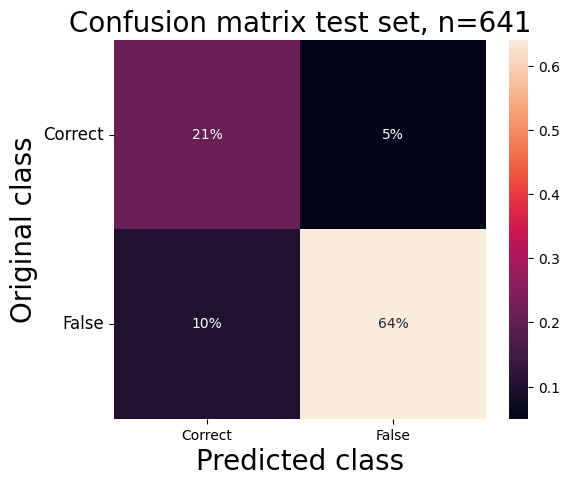

In [16]:
#mat = get_performance(y_test.values, pred, classNames2)
mat = [[21,5], [10,64]]
labels = y_test.values
capitalized = [i.capitalize() for i in class_names]
index = columns = capitalized
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(6,4.92))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title("Confusion matrix test set, n=641", fontsize=20)
plt.show()